# LELEC2885: Evaluation 1

*Overall instructions:*
- You have two hours to fill in this notebook.
- For each code cell, we specify if you must simply run it (`TO RUN`) or complete some code (`TO COMPLETE`). 
- Once you are done or the deadline (4pm) is approaching, save the notebook as `Evaluation1-Lastname-Firstname.ipynb` **with your outputs** and upload it on the moodle main page (there is a submission module on its main page).

- The final result is not the only thing that matters. The code clarity (which may imply comments) and answers to questions matter as well.
- If you are stuck, please add comments in code cells explaining why you feel you are stuck, what is your understanding of the situation.

## The context

We are going to try reading numbers that appear on an old photograph coming from your grandparents' house. It must have been the output of one of their crazy inventions.
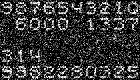

Both were engineers, and most of all, geeks. You are pretty sure it must contain meaningful numbers. Although you may be able to read it by yourself, you are afraid to make mistakes, and ask an Oracle to help you. The Oracle provides you with the right basis to start with so that you can do it with what you have learnt at the LELEC2885 course, because

> The journey matters much more than the end result.

## The project

Let us import the libraries that will be required, and observe the signals we have at hand.

In [1]:
# TO RUN
!pip install imageio numpy matplotlib

In [2]:
# TO RUN
import imageio
import numpy as np
import matplotlib.pyplot as plt

The "observation"


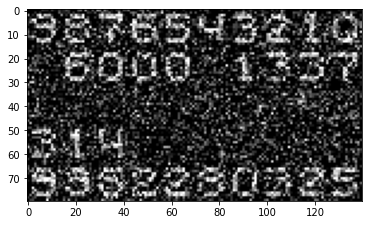

The "basis" provided by the oracle


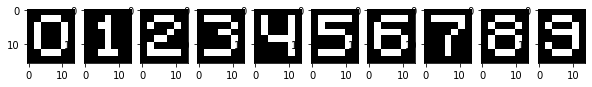

In [3]:
# TO RUN
Yold = imageio.imread("images/grandpa_photograph.png")/255
numbers =  (255-imageio.imread("images/numbers.png"))/255
numbers = [numbers[0:16,(i)*14:(i+1)*14] for i in range(10)]


print('The "observation"')
plt.imshow(Yold, cmap="gray")
plt.show()

Y = Yold.reshape(-1)

print('The "basis" provided by the oracle')

plt.figure(figsize=(10,20))
for i in range(len(numbers)):
    plt.subplot(1,10,i+1)
    plt.imshow(numbers[i], cmap="gray")
plt.show()

Thanks to the Oracle, you have a basic image for each number from 0 to 9.
You notice that each image has dimensions 14x16. 
Moreover, you observe that all the numbers appearing in your grandfather's old photograph are aligned on an 10x5 grid of such 14x16 rectangles.

**[Q1] Question:** Do you think Matching Pursuit is an adequate solution for this problem? Why? 

In [4]:
# Matching pursuit prend un dictionnaire avec dans ce cas ci les chiffres de 0 à 10 dans une grille de 10x5, on cherchera donc à maximiser la correlation d'un seul de ces chiffres à un endroit donné. 
# L'algorithme souffre donc de la parfaite localisation entre le chiffre testé dans le dico et celui de l'image observé. Si maintenant ils sont parfaitement aligné, nous pourrons en sortir le chiffre le plus correlé facilement. 

**[Q2] Question:** Are the different atoms orthogonal?

In [5]:
# Non, rien que les chiffres entre eux (16x14) ne sont pas linéairement indépendants, il suffit donc de prendre ces chiffres en x=0, y=0 (dans les atoms) pour se retrouver dans le même cas de figure que les chiffres simplement en 16x14

Although the image, and therefore the atoms, are 2D signals, we will reshape them as 1D vectors. For instance,  $Y_{old} \in \mathbb{R}^{80 \times 140}$ becomes $Y \in \mathbb{R}^{11200}$. Mathematically, one can model $Y$ as :

$$ Y = D \alpha + w $$

Where $D \in \mathbb{R}^{11200 \times 500}$ is a dictionary you will genuinely design and $\alpha \in \mathbb{R}^{500}$ are the coefficients inside the basis defined by $D$. You notice that $Y$ has been corrupted by additive noise $w \in \mathbb{R}^{11200}$ .

By choosing the right dictionary $D$, you should be able to recognize the numbers present in $Y$, thus also build a denoised version of this latter.

We will assume that $\alpha$ is $K$-sparse in $D$ for some sparsity value $K$. This leads us to formulating the following inverse problem :

$$ \hat{X} = D \hat{\alpha} \quad\quad \text{where} \quad\quad \hat{\alpha} = \arg \min_{\alpha} \frac{1}{2}\| Y - D\alpha \|_2^2 \quad s.t. \quad \|\alpha\|_0 \leq K,$$

where $\hat{\alpha}$ are the sparse coefficients describing the estimated clean image $\hat{X}$. 

**Your goal** is to find $\alpha$ by (approximately) solving this optimization problem with a **Matching Pursuit** algorithm, then deducing the denoised $\hat{X}$ afterwhile.

*Before we get started, let us import all the libraries we will need.*

# [Ex1] Building the dictionary

Let us now create the dictionary $D$ needed for the Matching Pursuit algorithm. 
We build a *lookup table* (a list of 500 (x,y,i) tuples ) to remember what every coefficient refers to, as required to transform the coefficient array into something meaningful.

In [6]:
print(numbers[0].shape)

(16, 14)


In [7]:
!# TO COMPLETE

print(f'Y shape : {Y.shape}')
d = 500
N = 11200 


D = np.zeros((10*14*5*16, 10*5*10))  # Why this shape ? -> N (observation flatten), d (on va placer 10 chiffres en hauteur, 5 chiffres en largeur et on va le faire pour chaque chiffre (10))
lookup = []

for x in range(10):
    for y in range(5):
        for i in range(len(numbers)):
            
            empty_atom = np.zeros((10*16, 14*5)) # declare the new empty atom with good shape (160, 70)

            empty_atom[16*x:16*(x+1), 14*y:14*(y+1)] = numbers[i].copy() # place the current (i) number at the good place (x,y)

            atom = empty_atom.flatten()  # Flatten to get same shape (11200,) as obs flattened

            atom = atom / (atom.T @ atom) # Normalize the atom

            D[:,len(lookup)] = atom
            lookup.append((x,y,i))
print(np.sum(D != 0))  # For the Teaching Assistants
print(D.shape)

Y shape : (11200,)
26800
(11200, 500)


## The Matching Pursuit algorithm

As a reminder, the Matching Pursuit (MP) algorithm works like :

<img src="images/MP.PNG" alt="MP algorithm" width="400"/>

Together, we will solve this optimization problem by coding a *Matching Pursuit* (MP) algorithm. Globally, it adds up to $K$ coefficients to $\alpha$ while greedily minimizing the norm of the *residual* $r := Y - D \alpha$.

### [Ex2] Atom selection

In [21]:

r = Yold.reshape(-1) # Starting with r = Y
N, d = D.shape
a_hat = np.zeros(d)

def MP_select_bestAtom(D,r):
    """Select the atom in D that is the most correlated with r."""
    
    inner = D.T @ r # inner product between all psi (dico) and r

    abs_inner = np.abs(inner) # get the absolute value 

    selected_atom_index = np.argmax(abs_inner) # get the best correlation between psi and r
    
    return selected_atom_index

i = MP_select_bestAtom(D,r)
selected_atom = D[:,i]
x, y, n = lookup[i]
print("According to your algorithm, there is a {} at position (x={},y={})".format(n,x,y))

(11200,)
According to your algorithm, there is a 1 at position (x=8,y=0)


### [Ex3] Coefficient update

In [9]:
# TO COMPLETE
def MP_coefficientUpdate(D,r,i):
    """Compute the coefficient update for atom i (to be added to the coefficient vector a)."""
    
    an = D[:,i].T @ r # get the inner product between the selected atom and residual 

    e_i = np.zeros(D.shape[1])
    e_i[i] = 1. # get the base vector

    coef_update = an * e_i # get the projection 
    
    coef_update = coef_update / (D[:,i].T @ D[:,i]) # normalize the coef_update (l2) 
    
    return coef_update

print("One update modifies {} coefficient(s), it should only update 1"
      .format((MP_coefficientUpdate(D,r,i)!=0).sum()))

One update modifies 1 coefficient(s), it should only update 1


### [Ex4] Residual update

In [10]:
# TO COMPLETE
def MP_updateResidual(x,D,a_hat):
    r = x - (D @ a_hat) # get the residual
    
    return r

r = MP_updateResidual(x,D,a_hat)

### Putting it all together

In [20]:
# TO RUN
def MatchingPursuit(x,D,K):
    """Implements the Matching Pursuit algorithm to approximately solve
        X_hat = min_X (1/2) ||Y - D X||^2_2     s.t.     ||X||_0 <= K.
    """
    
    # Initialization
    (N,d) = D.shape
    a_hat = np.zeros(d)
    r = x
    
    # Matching Pursuit algorithm, it calls the functions you implemented above!
    for k in range(K):
        # Step 1
        i = MP_select_bestAtom(D,r)
        # Step 2
        a_hat += MP_coefficientUpdate(D,r,i)
        # Step 3
        r = MP_updateResidual(x,D,a_hat)

    return a_hat

### It is time for some interesting stuff !

Let us now execute that matching pursuit and transcribe the results in a string.

**[Q3] Question:** Which value of K would you choose, intuitively?

In [12]:
# Autour de 50 moins les espaces sans chiffres dans l'image observée

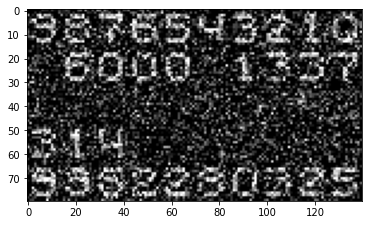

Transcription:

87      14
8414  1 14
9184    94
1484    84
6491    84


In [13]:
# TO RUN
K = 30 # Don't hesitate to play with K
a_hat = MatchingPursuit(Y, D, K)

transcription = [[" " for _ in range(10)] for _ in range(5)]
# At every position, only keep the atom with best score
best_scores = np.zeros((5,10))

for i in range(d):
    x, y, n = lookup[i]
    if abs(a_hat[i]) > best_scores[y,x]:
        transcription[y][x] = str(n)
        best_scores[y,x] = abs(a_hat[i])
    
plt.imshow(Yold, cmap="gray")
plt.show()
print("Transcription:\n")
print("\n".join(''.join(l) for l in transcription))

### An easy to beat benchmark

Although this is no strict ground truth, here is our solution with `K=30`:

```
9876543210
 6000  337
          
314       
9962280325
```

### [Ex5] Renovating the old photograph

Show us your result of the obtained clean image, in the same format as $Y_{old}$!

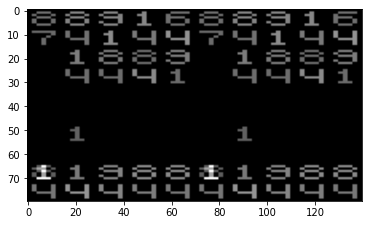

In [14]:
# TO COMPLETE
Y_hat = D @ a_hat

X_hat = Y_hat.reshape((80, 140))

plt.imshow(X_hat, cmap="gray")
plt.show()

**[Q4] Question:** Do you observe something particular in the reconstruction? Can you explain it? 

In [15]:
# Certains atoms ressortent avec de grandes certitudes + le cadre semble faire 8x10 chiffres dans l'espace 

**[Q5] Question:** Remember your answer to the last question (the value of K). Would you trust what appears for higher values of $K$ ? Why?

In [16]:
# Plus on va augmenter K, plus on va additionner des détails de moins en moins fortement correlé avec l'image de base et donc additionner des détails dû au bruit (oversampling)

**[Q6] Question**: Do you think the Orthogonal Matching Pursuit (OMP) would have given different results? Why?

In [17]:
# Ici on cherche un seul candidat dans les atoms, alors que OMP essayera de matcher plusieurs atoms en même temps.

#### That's all for today! Please ensure you answered to all the questions!

# BONUS
### [Ex6] Iterative Hard Thresholding (IHT)

The MP algorithm is not the only one allowing to partly solve the inverse problem. 

During the class you have seen the IHT algorithm. Here is how it works :

<img src="images/IHT.PNG" alt="IHT algorithm" width="400"/>

Complete the hard thresholding function

In [18]:
# TO COMPLETE
def thresh_hard(u,T):
    """Hard threshold u with threshold T
    """

    u[np.abs(u) <= T] = .0 # Set 0 to u between [-T, T]

    return u

Write the IHT algorithm and show us the result!

In [19]:
# TO COMPLETE

# Initialization
k = 0
a_hat = np.zeros(d)

# The parameters (finely tuned for your convenience :) ) 
mu = 0.1 # The gradient descent step
T = 0.2 # The threshold
da = 10 # The difference between the old and current value of a_hat

while k<40 and da>0.001 : # You might be removing the condition on da at the beginning!
    # TO COMPLETE

    k+=1

# TO COMPLETE
X_hat = ...

plt.imshow(X_hat, cmap="gray")
plt.show()

TypeError: Image data of dtype object cannot be converted to float